# 1.Install Dependencies (libraries)

In [5]:
!pip install matplotlib
!pip install opencv-python
!pip install scikit-learn
!pip install tensorflow
!pip install mediapipe

In [6]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp

# 2.Keypoints using mp holistic

In [7]:
mp_holistic = mp.solutions.holistic #Holistic Model
mp_drawing = mp.solutions.drawing_utils # drawing utils

In [8]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)  # color conversion
    image.flags.writeable=False                    # image is no longer writeable
    results = model.process(image)                 # make predictions
    image.flags.writeable=True                     # image is writeable
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)  # color conversion
    return image,results

In [9]:
def draw_styled_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(80,110,10),thickness=1,circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,256,121),thickness=1,circle_radius=1))
    mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10),thickness=2,circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121),thickness=2,circle_radius=2))
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76),thickness=2,circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250),thickness=2,circle_radius=2))
    mp_drawing.draw_landmarks(image,results.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,56),thickness=2,circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,240),thickness=2,circle_radius=2))

In [10]:
def draw_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image,results.right_hand_landmarks,mp_holistic.HNAD_CONNECTIONS)

In [11]:
import cv2

# Initialize the video capture object
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():
        # Capture frame-by-frame
        ret, frame = cap.read()
        
        # make detections
        image,results = mediapipe_detection(frame,holistic)
        print(results)

        draw_styled_landmarks(image,results)
        
        
        # Display the resulting frame
        cv2.imshow("OpenCV Read", image)
        
        # Break the loop if 'q' is pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    # Release the video capture object and close the display window
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

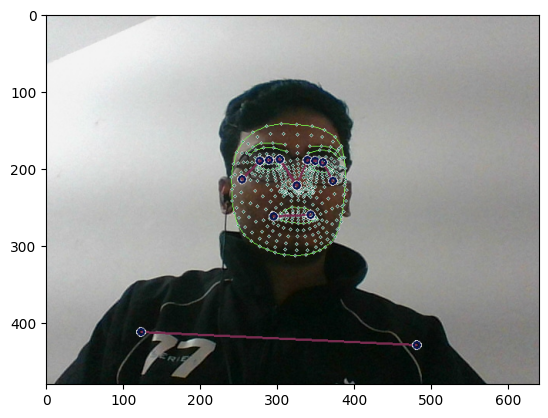

In [12]:
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

In [13]:
len(results.pose_landmarks.landmark)

33

In [14]:
pose=[]
for res in results.pose_landmarks.landmark:
    test = np.array([res.x,res.y,res.z,res.visibility])
    pose.append(test)

In [15]:
pose.shape

AttributeError: 'list' object has no attribute 'shape'

In [16]:
33*4

132

In [17]:
test

array([ 3.42624992e-01,  3.34075308e+00, -5.63004732e-01,  6.70736408e-05])

In [18]:
pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten()

In [19]:
pose.shape

(132,)

In [20]:
def extract_keypoints(results):
    lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3,)
    rh = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3,)
    pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4,)
    face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3,)
    return np.concatenate([pose,face,lh,rh])

In [21]:
len(results.face_landmarks.landmark)*3

1404

In [22]:
extract_keypoints(results).shape

(1662,)

In [23]:
1404+132+21*3+21*3

1662

# 4.Setup Folders for Data Collection

In [24]:
DATA_PATH = os.path.join('HMP_DATA')   # path for the exported data
actions=np.array(['hello','thanks','iloveyou'])  #actions we are trying to detect
no_sequences=30   #thirty videos worth of data
sequence_length = 30 #videos are going to be 30 frames in length

In [25]:
for action in actions:
    for sequence in range(no_sequences):
        try:
           os.makedirs(os.path.join(DATA_PATH,action,str(sequence)))
        except:
            pass

# 5.Collect Keypoint value for training and testing

In [26]:
import cv2

# Initialize the video capture object
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence = 0.5) as holistic:
    for action in actions: #loop through actions
        for sequence in range(no_sequences): #loop through sequences(videos)
            for frame_num in range(sequence_length): #loop through sequence length(video length)
                
                # Capture frame-by-frame
                ret, frame = cap.read()
                
                # make detections
                image,results = mediapipe_detection(frame,holistic)
                print(results)
        
                draw_styled_landmarks(image,results)
                # Apply Wait Logic
                if frame_num == 0:
                    cv2.putText(image,'Starting Collection',(120,200),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),4,cv2.LINE_AA)
                    cv2.putText(image,'Collecting frames for {} Video number {}'.format(action,sequence),(15,12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    cv2.waitKey(2000) #To give time to change pose
                else: 
                    cv2.putText(image,'Collecting frames for {} Video number {}'.format(action,sequence),(15,12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)

                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH,action,str(sequence),str(frame_num))
                np.save(npy_path,keypoints)
                # Display the resulting frame
                cv2.imshow("OpenCV Read", image)
                
                # Break the loop if 'q' is pressed
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    
    # Release the video capture object and close the display window
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [27]:
cap.release()
cv2.destroyAllWindows()

# 6.Preprocess data and create features and labels

In [28]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [29]:
label_map = {label:num for num,label in enumerate(actions)}

In [30]:
label_map

{np.str_('hello'): 0, np.str_('thanks'): 1, np.str_('iloveyou'): 2}

In [31]:
sequences,labels=[],[]

for action in actions:
    for sequence in range(no_sequences):
       window = []
       for frame_num in range(sequence_length): 
           res = np.load(os.path.join(DATA_PATH,action,str(sequence),"{}.npy".format(frame_num)))
           window.append(res)
       sequences.append(window)
       labels.append(label_map[action])

In [32]:
np.array(sequences).shape

(90, 30, 1662)

In [33]:
X=np.array(sequences)

In [34]:
X.shape

(90, 30, 1662)

In [35]:
y=to_categorical(labels).astype(int)

In [36]:
y.dtype

dtype('int64')

In [37]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [38]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.05)

In [39]:
X_train.shape

(85, 30, 1662)

# 7.Build and train LSTM Neural Network

In [40]:
import keras
from keras import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import TensorBoard

In [41]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [42]:
model = Sequential()
model.add(LSTM(64,return_sequences = True,activation='relu',input_shape = (30,1662)))
model.add(LSTM(128,return_sequences=True,activation='relu'))
model.add(LSTM(64,return_sequences=False,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))

C:\Users\HARDIK\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
model.add(Dense(actions.shape[0],activation='softmax'))

In [44]:
actions.shape[0]

3

In [45]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │         442,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 596,675 (2.28 MB)

 Trainable params: 596,675 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['categorical_crossentropy'])

In [ ]:
model.fit(X_train,y_train,epochs=1000)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - categorical_crossentropy: 1.9761 - loss: 1.9761
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - categorical_crossentropy: 4.0611 - loss: 4.0611
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - categorical_crossentropy: 15.8317 - loss: 15.8317 
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - categorical_crossentropy: 12.3106 - loss: 12.3106
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - categorical_crossentropy: 27.0281 - loss: 27.0281 
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - categorical_crossentropy: 16.9036 - loss: 16.9036 
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - categorical_crossentropy: 20.0488 - loss: 20.0488 
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - categorical_crossentropy: 20.0607 - loss: 20.0607
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - categorical_crossentropy: 44.2805 - loss: 44.2805 
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - categorical_cro

In [48]:
res=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


In [49]:
res[0]

array([1.6903081e-14, 9.9998891e-01, 1.1105934e-05], dtype=float32)

In [50]:
actions[np.argmax(res[4])]

np.str_('thanks')

In [51]:
actions[np.argmax(y_test[4])]

np.str_('iloveyou')

In [52]:
model.evaluate(X_train,y_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - categorical_crossentropy: 0.5236 - loss: 0.5236 


[0.542778730392456, 0.542778730392456]

In [53]:
model.save('action.h5')

In [54]:
model.save('action_new_format.keras')

# 8.Evaluation using confusion matrix and accuracy

In [55]:
from sklearn.metrics import multilabel_confusion_matrix,accuracy_score

In [56]:
yhat=model.predict(X_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step 


In [57]:
ytrue=np.argmax(y_train,axis=1).tolist()
yhat=np.argmax(yhat,axis=1).tolist()

In [58]:
accuracy_score(ytrue,yhat)

0.7529411764705882

In [59]:
multilabel_confusion_matrix(ytrue,yhat)

array([[[55,  0],
        [19, 11]],

       [[56,  2],
        [ 0, 27]],

       [[38, 19],
        [ 2, 26]]])

In [63]:
accuracy_score(ytrue, yhat)

0.7529411764705882

# 9.Test in Real time

In [60]:
from scipy import stats

In [64]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [65]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

TypeError: only length-1 arrays can be converted to Python scalars

<Figure size 1800x1800 with 0 Axes>

In [66]:
cap.release()

In [67]:
cv2.destroyAllWindows()

In [68]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [69]:
cap.release()

In [70]:
cv2.destroyAllWindows()